In [1]:
import numpy as np
import pandas as pd
import fastparquet
from pandasql import sqldf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import string

/Users/isabellajohansson/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Data pre processing: ....copied from before
transactions = pd.read_parquet("data_science_take_home_transactions.parquet", engine='pyarrow')
advances = pd.read_parquet("data_science_take_home_advances.parquet", engine='pyarrow')

###1. Convert 'account_id' to numerical values
# Create a copy of the 'account_id' column as 'account_id_string'
transactions['account_id_string'] = transactions['account_id'].copy()
advances['account_id_string'] = advances['account_id'].copy()

label_encoder = LabelEncoder() # Create a label encoder object

transactions['account_id'] = label_encoder.fit_transform(transactions['account_id']) # Transform 'account_id' column to numerical values and replace the original column 
advances['account_id'] = label_encoder.fit_transform(advances['account_id'])

###2. Only looking at postivie numbers and ignoring charges (for now?).
#Noticed that for payment_channel: "online" and "in-store" can be filtered out bc they seem to exclude salaries.
selected_data = transactions[(transactions['payment_channel'] != 'online') &
                             (transactions['payment_channel'] != 'in store') ]#&
                             #(transactions['f0_'] > 0)]
###3. Lets ignore irrelevant columns: 

columns_to_remove = ['version', 'currency_code', 'pending', 'removed', 'selected_data', 'city', 'region', 'payment_meta_payment_processor',
                    'authorized_date', 'payment_meta_payment_method', 'payment_channel']
cleaned_data = selected_data.drop(columns=columns_to_remove, axis=1, errors='ignore')

# Let's ensure the 'date' column is converted to a datetime format before using the .dt accessor. 
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])

# Feature Engineering: Extract features from dates and descriptions
cleaned_data['day_of_week'] = cleaned_data['date'].dt.dayofweek
cleaned_data['week_number'] = cleaned_data['date'].dt.isocalendar().week
cleaned_data['month'] = cleaned_data['date'].dt.month

#cleaned_data

# Lets analyze distinct accounts to try and predict if they qualify for a loan based on f0_ and dates. 

# Lets look at: account balance, income stability, spending habits and frequency of transactions...

# Lets start by plotting positive f0_ (deposits) and negative f0_ (withdrawls) per month and per week.

In [119]:
#account_ids = [1665, 213, 736, 1633, 141]

# Filter transactions for the specified account_id
account_data = cleaned_data[cleaned_data['account_id'] ==1665]

In [120]:
print("Minimum date:", account_data['date'].min())
print("Maximum date:", account_data['date'].max())
from dateutil.relativedelta import relativedelta
total_time_span = relativedelta(account_data['date'].max(), account_data['date'].min())
total_months = total_time_span.years * 12 + total_time_span.months
print("Total time span:", total_months, "months")

Minimum date: 2021-11-01 00:00:00
Maximum date: 2022-12-30 00:00:00
Total time span: 13 months


# (1) account balance binned in time - first by month and then by week.

Number of months where withdrawals exceed deposits: 0
Average amount by which withdrawals exceed deposits: nan
Percentage of months where withdrawals exceed deposits: 0.0


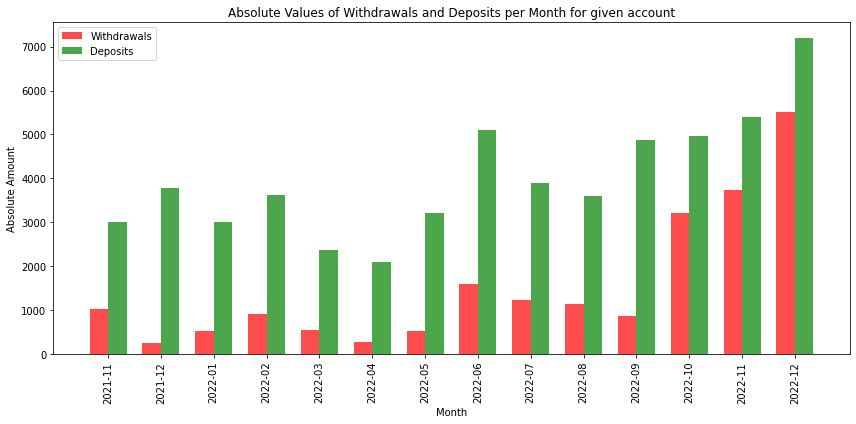

In [121]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'account_data' is your DataFrame containing the transactional data

# Separate withdrawals and deposits
withdrawals = account_data[account_data['f0_'] < 0]['f0_'].abs()
deposits = account_data[account_data['f0_'] > 0]['f0_'].abs()

# Group the data by month and calculate the sum of absolute values of withdrawals and deposits
withdrawals_monthly = withdrawals.groupby(account_data['date'].dt.to_period('M')).sum()
deposits_monthly = deposits.groupby(account_data['date'].dt.to_period('M')).sum()

# Align the two DataFrames on the index
withdrawals_monthly, deposits_monthly = withdrawals_monthly.align(deposits_monthly, fill_value=0)

# Create positions for the bars
months = withdrawals_monthly.index.astype(str)
bar_width = 0.35
index = np.arange(len(months))

# Plot a histogram for absolute values of withdrawals and deposits
fig, ax = plt.subplots(figsize=(12, 6))  # Adjusted figure size for better visualization

# Plot absolute values of withdrawals
ax.bar(index, withdrawals_monthly, width=bar_width, color='red', alpha=0.7, label='Withdrawals')
# Plot absolute values of deposits next to withdrawals
ax.bar(index + bar_width, deposits_monthly, width=bar_width, color='green', alpha=0.7, label='Deposits')

# Calculate the difference between withdrawals and deposits for each month where withdrawals exceed deposits
excess_differences = (withdrawals_monthly - deposits_monthly)[withdrawals_monthly > deposits_monthly]

# Print the number of months where withdrawals exceed deposits
num_exceeding_months = np.sum(withdrawals_monthly > deposits_monthly)
print("Number of months where withdrawals exceed deposits:", num_exceeding_months)

# Print the average amount by which withdrawals exceed deposits
average_excess = excess_differences.mean()
print("Average amount by which withdrawals exceed deposits:", average_excess)

total_months = len(withdrawals_monthly)
percent_exceeding_months = (num_exceeding_months / total_months) * 100
print("Percentage of months where withdrawals exceed deposits:", percent_exceeding_months)


# Add a symbol on months where withdrawals exceed deposits
for i, (withdrawal, deposit) in enumerate(zip(withdrawals_monthly, deposits_monthly)):
    if withdrawal > deposit:
        ax.text(i + bar_width / 2, max(withdrawal, deposit), '*', ha='center', va='bottom', color='black', fontsize=25)

# Customize the plot
ax.set_title('Absolute Values of Withdrawals and Deposits per Month for given account')
ax.set_xlabel('Month')
ax.set_ylabel('Absolute Amount')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(months, rotation=90)  # Rotate x-axis tick labels by 90 degrees for readability

# Add a label in the legend for "Withdrawals exceed Deposits"
ax.legend(['Withdrawals', 'Deposits', 'Withdrawals > Deposits'])

plt.tight_layout()
plt.show()



Number of weeks where withdrawals exceed deposits: 3
Average amount by which withdrawals exceed deposits: 184.93666666666664
Percentage of weeks where withdrawals exceed deposits: 4.918032786885246


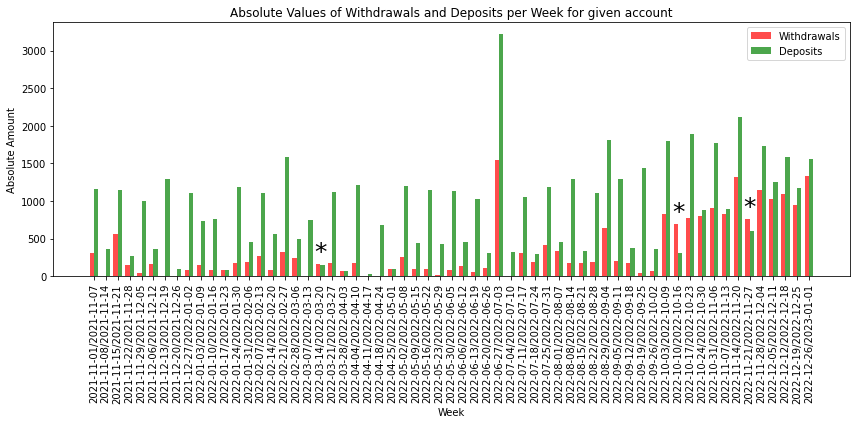

In [122]:
# Separate withdrawals and deposits
withdrawals = account_data[account_data['f0_'] < 0]['f0_'].abs()
deposits = account_data[account_data['f0_'] > 0]['f0_'].abs()

# Group the data by week and calculate the sum of absolute values of withdrawals and deposits
withdrawals_weekly = withdrawals.groupby(account_data['date'].dt.to_period('W')).sum()
deposits_weekly = deposits.groupby(account_data['date'].dt.to_period('W')).sum()

# Align the two DataFrames on the index
withdrawals_weekly, deposits_weekly = withdrawals_weekly.align(deposits_weekly, fill_value=0)

# Create positions for the bars
weeks = withdrawals_weekly.index.astype(str)
bar_width = 0.35
index = np.arange(len(weeks))

# Plot a histogram for absolute values of withdrawals and deposits
fig, ax = plt.subplots(figsize=(12, 6))  # Adjusted figure size for better visualization

# Plot absolute values of withdrawals
ax.bar(index, withdrawals_weekly, width=bar_width, color='red', alpha=0.7, label='Withdrawals')
# Plot absolute values of deposits next to withdrawals
ax.bar(index + bar_width, deposits_weekly, width=bar_width, color='green', alpha=0.7, label='Deposits')

# Calculate the difference between withdrawals and deposits for each week where withdrawals exceed deposits
excess_differences = (withdrawals_weekly - deposits_weekly)[withdrawals_weekly > deposits_weekly]

# Print the average amount by which withdrawals exceed deposits
num_exceeding_weeks = np.sum(withdrawals_weekly > deposits_weekly)
print("Number of weeks where withdrawals exceed deposits:", num_exceeding_weeks)

average_excess = excess_differences.mean()
print("Average amount by which withdrawals exceed deposits:", average_excess)

# Print the percentage of weeks where withdrawals exceed deposits
total_weeks = len(withdrawals_weekly)
percent_exceeding_weeks = (num_exceeding_weeks / total_weeks) * 100
print("Percentage of weeks where withdrawals exceed deposits:", percent_exceeding_weeks)



# Add a symbol on weeks where withdrawals exceed deposits
for i, (withdrawal, deposit) in enumerate(zip(withdrawals_weekly, deposits_weekly)):
    if withdrawal > deposit:
        ax.text(i + bar_width / 2, max(withdrawal, deposit), '*', ha='center', va='bottom', color='black', fontsize=25)

# Customize the plot
ax.set_title('Absolute Values of Withdrawals and Deposits per Week for given account')
ax.set_xlabel('Week')
ax.set_ylabel('Absolute Amount')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(weeks, rotation=90)  # Rotate x-axis tick labels by 90 degrees for readability

# Add a label in the legend for "Withdrawals exceed Deposits"
ax.legend(['Withdrawals', 'Deposits', 'Withdrawals > Deposits'])

plt.tight_layout()
plt.show()

In [123]:
# Group the data by week and calculate the sum of f0_ values for each week
weekly_net_f0 = account_data.groupby(account_data['date'].dt.to_period('W'))['f0_'].sum()

# Filter the weeks where the net f0_ value is negative
negative_weeks = weekly_net_f0[weekly_net_f0 < 0]

# Print the dates corresponding to the negative net f0_ weeks
print("Weeks with withdrawls > deposit")
for week_start_date in negative_weeks.index.to_timestamp():
    week_end_date = week_start_date + pd.DateOffset(days=6)  # Assuming weeks end on Sunday
    print("Week:", week_start_date.strftime('%Y-%m-%d'), "-", week_end_date.strftime('%Y-%m-%d'))

Weeks with withdrawls > deposit
Week: 2022-03-14 - 2022-03-20
Week: 2022-10-10 - 2022-10-16
Week: 2022-11-21 - 2022-11-27


## We may also look some averages.. if we notice red flags

In [124]:
# Identify income transactions (assuming credits represent income)
income_transactions = account_data[account_data['f0_'] > 0]

# Calculate average monthly income
total_income = income_transactions['f0_'].sum()
num_months = len(income_transactions['date'].dt.to_period('M').unique())
average_monthly_income = total_income / num_months

# Calculate standard deviation of income amounts
income_std_dev = income_transactions['f0_'].std()
# Calculate frequency of income deposits (assuming monthly frequency)
num_income_deposits = len(income_transactions)
num_months = len(income_transactions['date'].dt.to_period('M').unique())
income_frequency = num_income_deposits / num_months


expense_transactions = account_transactions[account_transactions['f0_'] < 0]
total_expenses = expense_transactions['f0_'].sum()

# Print results
print("Average Monthly Income:", average_monthly_income)
print("Standard Deviation of Income Amounts:", income_std_dev)
print("Frequency of Income Deposits (per month):", income_frequency)

# Compare income to expenses
if total_income > abs(total_expenses):
    print("Income exceeds expenses by:", total_income - abs(total_expenses))
elif total_income < abs(total_expenses):
    print("Expenses exceed income by:", abs(total_expenses) - total_income)
else:
    print("Income equals expenses")

Average Monthly Income: 4009.3514285714286
Standard Deviation of Income Amounts: 295.13403789813526
Frequency of Income Deposits (per month): 25.428571428571427
Income exceeds expenses by: 51720.81


# Observations:
## - Account 1665: balance seems to be stable making this person eligble for a loan. no red flags

## - Accont 213: this account seems to have "unhealty" spending habbits. Red flags in terms of Percentage of weeks where withdrawals exceed deposits: 57%

## - Account 736 - looks stable on monthly basis but not weekly.

## - Account 1633 - stable


## Add month to week ratio? Averge monthly income-to-income exceeds expenses by-ratio...

## if  (Weeks with withdrawls > deposit) >> (Months with withdrawls > deposit) it probalby just means that they are paid on a monthey basis

### Might want to ignore outliers? (For ex: A one time large deposit may misrepresent account holders overall average) 

### Add minimum data requered (say 6 months old account?)

### Next: make a decision tree to classify loan eligbility...

### In terms of spending--Do we accsess "Merchant Category Codes (MCCs)"? https://stripe.com/docs/issuing/categories or are these the codes in the names? These could help us evalaue  spending habbits. 
